# Modeling Catalina QSO light curves with an Auto encoder model

Brett et al. 2017 applied the auto-encoder model to 50,124 light curves from the All Sky Automated Survey (ASAS) Catalog of Variable stars and then got auto-encoded features which can be used for the classification of variable stars. 
The classification with the auto-encoded features shows the comparable or sometimes outperform the human-made features. 

Then our motivation is obtaining useful features of the QSO light curves and modeling/forecasting it with the auto-encoder model. 
In this notebook I have checked the performance and the result with very preliminary auto-encoder structure. 

For constructing the auto-encoder I used keras in this time. 

In [1]:
import sys
sys.path.append('./IrregularTimeSeriesAutoencoder')
import numpy as np
import pandas as pd
from keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, merge,
                          Flatten, RepeatVector, Recurrent, Bidirectional, SimpleRNN)
from keras.models import Model
import keras_util as ku
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display_png, display_pdf

Using TensorFlow backend.


I used 'keras_util' (https://github.com/bnaul/IrregularTimeSeriesAutoencoderPaper) and structure of the encoder/decoder described in there.

The architecture shown in Brett et al. (2017). 

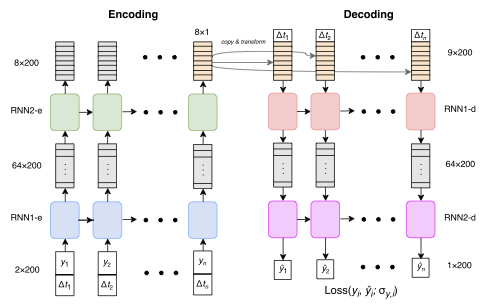

In [247]:
display_png(Image('./Auto_Encoder.png'))

### Encoder

In [2]:
def encoder(model_input, layer, size, num_layers, drop_frac=0.25, output_size=None,
            bidirectional=False, **parsed_args):
    if output_size is None:
        output_size = size
    encode = model_input
    for i in range(num_layers):
        wrapper = Bidirectional if bidirectional else lambda x: x
        encode = wrapper(layer(size, name='encode_{}'.format(i),
                               return_sequences=(i < num_layers - 1)))(encode)
        if drop_frac > 0.0:
            encode = Dropout(drop_frac, name='drop_encode_{}'.format(i))(encode)
    encode = Dense(output_size, activation='linear', name='encoding')(encode)
    return encode

###########################
print(
    """Encoder module of autoencoder architecture.

    Can be used either as the encoding component of an autoencoder or as a standalone
    encoder, which takes (possibly irregularly-sampled) time series as inputs and produces
    a fixed-length vector as output.

    model_input: `keras.layers.Input`
        Input layer containing (y) or (dt, y) values
    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    output_size: int, optional
        Size of encoding layer; defaults to `size`
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    """
)
###########################

Encoder module of autoencoder architecture.

    Can be used either as the encoding component of an autoencoder or as a standalone
    encoder, which takes (possibly irregularly-sampled) time series as inputs and produces
    a fixed-length vector as output.

    model_input: `keras.layers.Input`
        Input layer containing (y) or (dt, y) values
    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    output_size: int, optional
        Size of encoding layer; defaults to `size`
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    


### Decoder

In [3]:
def decoder(encode, layer, n_step, size, num_layers, drop_frac=0.25, aux_input=None,
            bidirectional=False, **parsed_args):
    
    decode = RepeatVector(n_step, name='repeat')(encode)
    if aux_input is not None:
        decode = merge([aux_input, decode], mode='concat')

    for i in range(num_layers):
        if drop_frac > 0.0 and i > 0:  # skip these for first layer for symmetry
            decode = Dropout(drop_frac, name='drop_decode_{}'.format(i))(decode)
        wrapper = Bidirectional if bidirectional else lambda x: x
        decode = wrapper(layer(size, name='decode_{}'.format(i),
                               return_sequences=True))(decode)

    decode = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decode)
    return decode

###########################
print(
    """Decoder module of autoencoder architecture.

    Can be used either as the decoding component of an autoencoder or as a standalone
    decoder, which takes a fixed-length input vector and generates a length-`n_step`
    time series as output.

    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    n_step: int
        Length of output time series
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    aux_input: `keras.layers.Input`, optional
        Input layer containing `dt` values; if `None` then the sequence is assumed to be
        evenly-sampled
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    """
)
###########################

Decoder module of autoencoder architecture.

    Can be used either as the decoding component of an autoencoder or as a standalone
    decoder, which takes a fixed-length input vector and generates a length-`n_step`
    time series as output.

    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    n_step: int
        Length of output time series
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    aux_input: `keras.layers.Input`, optional
        Input layer containing `dt` values; if `None` then the sequence is assumed to be
        evenly-sampled
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    


### Loading Catalina light curves

In [4]:
import subprocess
def load_lcs(pass_to_lc_dir):
    command = 'ls ' + str(pass_to_lc_dir)
    lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')
    del lc_files[len(lc_files)-1]
    print('Loading %d data:'%len(lc_files))
    X = [np.r_[np.array(pd.read_csv('./lcs/'+str(lc_files[i]), header=None, sep=' ')).tolist()] for i in range(len(lc_files))]
    print('Finish.')
    return  X

In [19]:
X_list = load_lcs('./lcs/')

Loading 4227 data:
Finish.


Example of the loaded data: [MJD, MAG, ERR]

In [21]:
X_list[0][0:3]

array([[  5.35634411e+04,   1.89311076e+01,   1.12301811e-01],
       [  5.36272669e+04,   1.86228614e+01,   1.13120127e-01],
       [  5.36363174e+04,   1.89534407e+01,   1.11743680e-01]])

Randomize the order of the list for avoiding the systematic effect of the index of the data. 

In [23]:
np.random.shuffle(X_list)
X_list[0][0:3]

array([[  5.34642160e+04,   1.81742509e+01,   6.53732766e-02],
       [  5.34811906e+04,   1.79577590e+01,   9.73836324e-02],
       [  5.34941461e+04,   1.80139406e+01,   6.02745120e-02]])

In [24]:
from keras.preprocessing.sequence import pad_sequences
X_raw = pad_sequences(X_list, value=np.nan, dtype='float', padding='post')

### Preprocess for the input data: 

MJD -> $\Delta$MJD

mag -> [mag - mean(mag)]/std(mag)

In [25]:
def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = ku.times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    return X, means, scales, errors, wrong_units

In [26]:
X, means, scales, errors, wrong_units = preprocess(X_raw)
main_input = Input(shape=(X.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(X.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


w = 1/err, loss = [w(y-y$_{\rm pred}$)]$^2$ (reduced $\chi$ squre)

In [27]:
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
X[np.isnan(X)] = 0.

Encoder

    RNN: GRU

    Number of units within each hidden layer: 64

    Number of hidden layers: 5

    Size of encoding layer=64

    Dropout rate = 0.25 

    bidirectional version of 'layer' is used
    
Decoder

    RNN: GRU

    Number of units within each hidden layer: 64

    Number of hidden layers: 5

    Size of encoding layer=64

    Dropout rate = 0.25 

In [28]:
encode = encoder(main_input, layer=GRU, size=64, num_layers=5, output_size=64, drop_frac=0.25, bidirectional=True)
decode = decoder(encode, layer=GRU, size=64, num_layers=5,  n_step=X.shape[1], drop_frac=0.25, aux_input=aux_input)
model = Model(model_input, decode)

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [29]:
lr = 1e-3 #learning rate 

In [30]:
from keras.optimizers import Adam
import os

optimizer = Adam(lr=lr)

log_dir = os.path.join(os.getcwd(), 'keras_logs', 'test')
log_dir += "_ft{:1.0e}".format(lr).replace('e-', 'm')
weights_path = os.path.join(log_dir, 'weights.h5')

print("""log directory: {0} \n
weight pass: {1} """.format(log_dir, weights_path))

log directory: /Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03 

weight pass: /Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03/weights.h5 


In [33]:
#model.load_weights(weights_path)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

In [34]:
import shutil
shutil.rmtree(log_dir, ignore_errors=True)
os.makedirs(log_dir)

In [35]:
from keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
from keras_tqdm import TQDMCallback
import sys
import csv
from collections import Iterable, OrderedDict
import datetime

class Progbar(TQDMCallback):  # redirect TQDMCallback to stdout
    def __init__(self):
        TQDMCallback.__init__(self)
        self.output_file = sys.stdout
class TimedCSVLogger(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        if not self.writer:
            self.keys = sorted(logs.keys())

            class CustomDialect(csv.excel):
                delimiter = self.sep

            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=['epoch', 'time'] + self.keys,
                                         dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()

        row_dict = OrderedDict({'epoch': epoch, 'time': str(datetime.datetime.now())})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()
class LogDirLogger(Callback):
    def __init__(self, log_dir):
        self.log_dir = log_dir 

    def on_epoch_begin(self, epoch, logs=None):
        print('\n' + self.log_dir + '\n')

In [36]:
history = model.fit({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)},
                    X[:, :, [1]], 
                    nb_epoch=1024, 
                    batch_size=256,
                    sample_weight=sample_weight,
                    callbacks=[Progbar(),
                           TensorBoard(log_dir=log_dir, write_graph=False),
                           TimedCSVLogger(os.path.join(log_dir, 'training.csv'), append=True),
                           ModelCheckpoint(weights_path, save_weights_only=True),
                           LogDirLogger(log_dir)], 
                    verbose=False,
                    validation_split=0.2,
                    validation_data=None)

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch: 0:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 2:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 3:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 4:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 5:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 6:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 6 - loss: 2.443:  15%|█▌        | 512/3381 [00:13<01:19, 36.13it/s]


Epoch: 7:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 8:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 9:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 10:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 11:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 12:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 12 - loss: 2.079:  45%|████▌     | 1536/3381 [00:31<00:37, 48.92it/s]


Epoch: 13:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 14:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 15:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 16:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 17:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 18:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 18 - loss: 1.917:  68%|██████▊   | 2304/3381 [00:46<00:22, 48.70it/s]


Epoch: 19:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 20:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 21:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 22:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 23:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 24:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 24 - loss: 1.838:  91%|█████████ | 3072/3381 [01:02<00:06, 48.30it/s]


Epoch: 25:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 26:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 27:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 28:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 29:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 30:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:   3%|▎         | 31/1024 [40:50<21:27:08, 77.77s/it]


Epoch: 31:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 32:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 33:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 34:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 35:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 36:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 37:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 37 - loss: 1.935:  15%|█▌        | 512/3381 [00:10<00:58, 49.46it/s]


Epoch: 38:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 39:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 40:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 41:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 42:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 43:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 43 - loss: 1.658:  38%|███▊      | 1280/3381 [00:26<00:44, 47.45it/s]


Epoch: 44:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 45:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 46:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 47:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 48:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 49:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 49 - loss: 1.719:  61%|██████    | 2048/3381 [00:41<00:26, 49.86it/s]


Epoch: 50:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 51:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 52:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 53:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 54:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 55:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 55 - loss: 1.651:  83%|████████▎ | 2816/3381 [00:56<00:11, 49.72it/s]


Epoch: 56:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 57:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 58:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 59:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 60:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 61:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 61 - loss: 1.615, val_loss: 1.645: 100%|██████████| 3381/3381 [01:16<00:00, 18.13it/s]


Epoch: 62:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 63:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 64:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 65:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 66:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 67:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 68:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 68 - loss: 1.527:   8%|▊         | 256/3381 [00:05<01:02, 50.30it/s]


Epoch: 69:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 70:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 71:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 72:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 73:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 74:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 74 - loss: 1.655:  30%|███       | 1024/3381 [00:21<00:49, 47.22it/s]


Epoch: 75:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 76:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 77:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 78:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 79:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 80:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 80 - loss: 1.545:  53%|█████▎    | 1792/3381 [00:39<00:33, 46.85it/s]


Epoch: 81:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 82:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 83:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 84:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 85:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 86:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 86 - loss: 1.583:  76%|███████▌  | 2560/3381 [00:52<00:16, 48.78it/s]


Epoch: 87:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 88:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 89:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 90:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 91:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 92:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 92 - loss: 1.549:  98%|█████████▊| 3328/3381 [01:08<00:01, 48.80it/s]


Epoch: 93:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 94:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 95:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 96:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 97:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 98:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 99:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 100:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 101:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 102:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 103:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 104:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 105:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 105 - loss: 1.587:  15%|█▌        | 512/3381 [00:10<00:58, 48.72it/s]


Epoch: 106:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 107:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 108:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 109:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 110:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 111:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 111 - loss: 1.519:  30%|███       | 1024/3381 [00:22<00:51, 46.07it/s]


Epoch: 112:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 113:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 114:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 115:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 116:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 117:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 117 - loss: 1.392:  45%|████▌     | 1536/3381 [00:33<00:39, 46.48it/s]


Epoch: 118:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 119:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 120:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 121:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 122:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 123:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 123 - loss: 1.454:  61%|██████    | 2048/3381 [00:42<00:27, 48.03it/s]


Epoch: 124:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 125:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 126:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 127:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 128:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 129:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 129 - loss: 1.416:  76%|███████▌  | 2560/3381 [00:53<00:17, 47.98it/s]


Epoch: 130:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 131:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 132:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 133:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 134:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 135:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 135 - loss: 1.406:  91%|█████████ | 3072/3381 [01:03<00:06, 48.08it/s]


Epoch: 136:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 137:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 138:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 139:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 140:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 141:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 141 - loss: 1.415:  98%|█████████▊| 3328/3381 [01:10<00:01, 47.81it/s]


Epoch: 142:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 143:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 144:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 145:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 146:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 147:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  14%|█▍        | 148/1024 [3:12:58<18:40:53, 76.77s/it]


Epoch: 148:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 149:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 150:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 151:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 152:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 153:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 154:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 155:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 156:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 157:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 158:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 159:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 160:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 160 - loss: 1.313:  15%|█▌        | 512/3381 [00:11<01:02, 46.14it/s]


Epoch: 161:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 162:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 163:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 164:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 165:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 166:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 166 - loss: 1.420:  30%|███       | 1024/3381 [00:21<00:49, 47.64it/s]


Epoch: 167:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 168:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 169:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 170:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 171:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 172:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 172 - loss: 1.323:  45%|████▌     | 1536/3381 [00:31<00:38, 47.94it/s]


Epoch: 173:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 174:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 175:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 176:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 177:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 178:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 178 - loss: 1.334:  61%|██████    | 2048/3381 [00:43<00:28, 47.42it/s]


Epoch: 179:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 180:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 181:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 182:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 183:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 184:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 184 - loss: 1.367:  76%|███████▌  | 2560/3381 [00:51<00:16, 49.02it/s]


Epoch: 185:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 186:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 187:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 188:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 189:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 190:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 190 - loss: 1.338:  91%|█████████ | 3072/3381 [01:03<00:06, 48.85it/s]


Epoch: 191:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 192:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 193:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 194:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 195:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 196:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 196 - loss: 1.329:  98%|█████████▊| 3328/3381 [01:07<00:01, 49.18it/s]


Epoch: 197:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 198:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 199:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 200:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 201:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 202:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  20%|█▉        | 203/1024 [4:23:18<17:47:47, 78.04s/it]


Epoch: 203:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 204:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 205:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 206:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 207:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 208:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 209:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 210:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 211:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 212:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 213:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 214:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 215:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 215 - loss: 1.391:  15%|█▌        | 512/3381 [00:11<01:04, 44.40it/s]


Epoch: 216:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 217:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 218:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 219:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 220:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 221:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 221 - loss: 1.281:  30%|███       | 1024/3381 [00:22<00:50, 46.38it/s]


Epoch: 222:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 223:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 224:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 225:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 226:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 227:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 227 - loss: 1.310:  45%|████▌     | 1536/3381 [00:33<00:40, 45.24it/s]


Epoch: 228:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 229:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 230:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 231:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 232:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 233:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 233 - loss: 1.262:  61%|██████    | 2048/3381 [00:45<00:29, 44.81it/s]


Epoch: 234:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 235:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 236:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 237:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 238:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 239:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 239 - loss: 1.310:  76%|███████▌  | 2560/3381 [00:57<00:18, 44.46it/s]


Epoch: 240:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 241:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 242:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 243:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 244:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 245:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 245 - loss: 1.264:  91%|█████████ | 3072/3381 [01:09<00:06, 44.74it/s]


Epoch: 246:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 247:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 248:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 249:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 250:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 251:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 251 - loss: 1.291:  98%|█████████▊| 3328/3381 [01:12<00:01, 45.57it/s]


Epoch: 252:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 253:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 254:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 255:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 256:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 257:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  25%|██▌       | 258/1024 [5:38:25<17:27:03, 82.02s/it]


Epoch: 258:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 259:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 260:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 261:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 262:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 263:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 264:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 265:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 266:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 267:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 268:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 269:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 270:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 270 - loss: 1.247:  15%|█▌        | 512/3381 [00:12<01:07, 42.34it/s]


Epoch: 271:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 272:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 273:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 274:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 275:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 276:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 276 - loss: 1.191:  30%|███       | 1024/3381 [00:22<00:51, 46.03it/s]


Epoch: 277:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 278:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 279:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 280:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 281:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 282:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 282 - loss: 1.263:  45%|████▌     | 1536/3381 [00:34<00:41, 44.62it/s]


Epoch: 283:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 284:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 285:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 286:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 287:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 288:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 288 - loss: 1.288:  61%|██████    | 2048/3381 [00:46<00:30, 44.22it/s]


Epoch: 289:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 290:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 291:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 292:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 293:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 294:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 294 - loss: 1.217:  76%|███████▌  | 2560/3381 [00:57<00:18, 44.32it/s]


Epoch: 295:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 296:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 297:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 298:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 299:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 300:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 300 - loss: 1.222:  91%|█████████ | 3072/3381 [01:08<00:06, 44.27it/s]


Epoch: 301:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 302:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 303:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 304:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 305:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 306:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 306 - loss: 1.244:  98%|█████████▊| 3328/3381 [01:16<00:01, 42.97it/s]


Epoch: 307:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 308:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 309:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 310:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 311:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 312:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  31%|███       | 313/1024 [6:53:53<16:13:31, 82.15s/it]


Epoch: 313:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 314:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 315:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 316:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 317:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 318:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 319:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 320:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 321:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 322:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 323:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 324:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 325:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 325 - loss: 1.286:  15%|█▌        | 512/3381 [00:11<01:05, 43.81it/s]


Epoch: 326:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 327:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 328:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 329:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 330:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 331:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 331 - loss: 1.178:  30%|███       | 1024/3381 [00:24<00:55, 42.59it/s]


Epoch: 332:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 333:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 334:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 335:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 336:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 337:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 337 - loss: 1.147:  45%|████▌     | 1536/3381 [00:34<00:41, 44.10it/s]


Epoch: 338:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 339:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 340:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 341:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 342:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 343:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 343 - loss: 1.175:  61%|██████    | 2048/3381 [00:46<00:30, 43.85it/s]


Epoch: 344:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 345:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 346:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 347:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 348:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 349:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 349 - loss: 1.183:  76%|███████▌  | 2560/3381 [00:57<00:18, 44.70it/s]


Epoch: 350:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 351:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 352:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 353:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 354:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 355:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 355 - loss: 1.180:  91%|█████████ | 3072/3381 [01:08<00:06, 45.39it/s]


Epoch: 356:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 357:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 358:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 359:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 360:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 361:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 361 - loss: 1.159:  98%|█████████▊| 3328/3381 [01:14<00:01, 45.02it/s]


Epoch: 362:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 363:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 364:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 365:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 366:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 367:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  36%|███▌      | 368/1024 [8:09:14<14:40:28, 80.53s/it]


Epoch: 368:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 369:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 370:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 371:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 372:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 373:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 374:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 375:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 376:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 377:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 378:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 379:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 380:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 380 - loss: 1.211:  15%|█▌        | 512/3381 [00:11<01:07, 42.76it/s]


Epoch: 381:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 382:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 383:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 384:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 385:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 386:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 386 - loss: 1.171:  30%|███       | 1024/3381 [00:23<00:54, 43.60it/s]


Epoch: 387:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 388:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 389:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 390:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 391:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 392:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 392 - loss: 1.155:  45%|████▌     | 1536/3381 [00:34<00:41, 44.02it/s]


Epoch: 393:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 394:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 395:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 396:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 397:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 398:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 398 - loss: 1.138:  61%|██████    | 2048/3381 [00:45<00:29, 44.88it/s]


Epoch: 399:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 400:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 401:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 402:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 403:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 404:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 404 - loss: 1.149:  76%|███████▌  | 2560/3381 [00:59<00:19, 43.04it/s]


Epoch: 405:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 406:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 407:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 408:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 409:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 410:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 410 - loss: 1.163:  91%|█████████ | 3072/3381 [01:09<00:07, 43.79it/s]


Epoch: 411:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 412:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 413:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 414:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 415:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 416:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 416 - loss: 1.135:  98%|█████████▊| 3328/3381 [01:15<00:01, 43.90it/s]


Epoch: 417:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 418:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 419:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 420:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 421:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 422:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  41%|████▏     | 423/1024 [9:23:47<13:25:47, 80.45s/it]


Epoch: 423:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 424:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 425:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 426:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 427:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 428:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 429:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 430:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 431:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 432:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 433:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 434:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 435:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 435 - loss: 1.143:  15%|█▌        | 512/3381 [00:10<01:01, 46.74it/s]


Epoch: 436:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 437:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 438:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 439:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 440:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 441:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 441 - loss: 1.155:  30%|███       | 1024/3381 [00:22<00:52, 45.10it/s]


Epoch: 442:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 443:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 444:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 445:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 446:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 447:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 447 - loss: 1.172:  45%|████▌     | 1536/3381 [00:33<00:40, 45.93it/s]


Epoch: 448:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 449:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 450:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 451:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 452:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 453:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 453 - loss: 1.136:  61%|██████    | 2048/3381 [00:47<00:30, 43.06it/s]


Epoch: 454:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 455:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 456:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 457:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 458:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 459:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 459 - loss: 1.102:  76%|███████▌  | 2560/3381 [00:55<00:17, 46.15it/s]


Epoch: 460:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 461:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 462:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 463:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 464:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 465:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 465 - loss: 1.111:  91%|█████████ | 3072/3381 [01:09<00:07, 43.84it/s]


Epoch: 466:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 467:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 468:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 469:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 470:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 471:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 471 - loss: 1.114:  98%|█████████▊| 3328/3381 [01:14<00:01, 44.81it/s]


Epoch: 472:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 473:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 474:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 475:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 476:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 477:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  47%|████▋     | 478/1024 [10:38:49<12:23:58, 81.76s/it]


Epoch: 478:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 479:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 480:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 481:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 482:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 483:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 484:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 485:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 486:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 487:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 488:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 489:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 490:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 490 - loss: 1.025:  15%|█▌        | 512/3381 [00:11<01:05, 43.98it/s]


Epoch: 491:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 492:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 493:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 494:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 495:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 496:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 496 - loss: 1.086:  30%|███       | 1024/3381 [00:22<00:52, 44.84it/s]


Epoch: 497:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 498:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 499:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 500:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 501:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 502:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 502 - loss: 1.077:  45%|████▌     | 1536/3381 [00:34<00:41, 44.95it/s]


Epoch: 503:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 504:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 505:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 506:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 507:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 508:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 508 - loss: 1.103:  61%|██████    | 2048/3381 [00:45<00:29, 45.09it/s]


Epoch: 509:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 510:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 511:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 512:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 513:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 514:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 514 - loss: 1.116:  76%|███████▌  | 2560/3381 [00:54<00:17, 46.73it/s]


Epoch: 515:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 516:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 517:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 518:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 519:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 520:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 520 - loss: 1.070:  91%|█████████ | 3072/3381 [01:06<00:06, 45.80it/s]


Epoch: 521:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 522:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 523:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 524:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 525:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 526:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 526 - loss: 1.092:  98%|█████████▊| 3328/3381 [01:15<00:01, 43.88it/s]


Epoch: 527:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 528:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 529:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 530:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 531:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 532:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  52%|█████▏    | 533/1024 [11:53:25<11:07:30, 81.57s/it]


Epoch: 533:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 534:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 535:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 536:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 537:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 538:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 539:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 540:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 541:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 542:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 543:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 544:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 545:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 545 - loss: 1.095:  15%|█▌        | 512/3381 [00:11<01:04, 44.82it/s]


Epoch: 546:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 547:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 548:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 549:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 550:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 551:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 551 - loss: 1.072:  30%|███       | 1024/3381 [00:21<00:50, 46.63it/s]


Epoch: 552:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 553:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 554:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 555:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 556:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 557:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 557 - loss: 1.063:  45%|████▌     | 1536/3381 [00:33<00:40, 45.37it/s]


Epoch: 558:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 559:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 560:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 561:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 562:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 563:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 563 - loss: 1.088:  61%|██████    | 2048/3381 [00:45<00:29, 45.18it/s]


Epoch: 564:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 565:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 566:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 567:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 568:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 569:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 569 - loss: 1.114:  76%|███████▌  | 2560/3381 [00:54<00:17, 46.89it/s]


Epoch: 570:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 571:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 572:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 573:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 574:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 575:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 575 - loss: 1.091:  91%|█████████ | 3072/3381 [01:09<00:07, 44.11it/s]


Epoch: 576:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 577:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 578:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 579:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 580:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 581:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 581 - loss: 1.097:  98%|█████████▊| 3328/3381 [01:14<00:01, 45.09it/s]


Epoch: 582:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 583:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 584:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 585:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 586:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 587:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  57%|█████▋    | 588/1024 [13:07:24<9:42:07, 80.11s/it]


Epoch: 588:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 589:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 590:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 591:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 592:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 593:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 594:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 595:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 596:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 597:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 598:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 599:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 600:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 600 - loss: 1.175:  15%|█▌        | 512/3381 [00:11<01:04, 44.15it/s]


Epoch: 601:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 602:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 603:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 604:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 605:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 606:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 606 - loss: 1.016:  30%|███       | 1024/3381 [00:23<00:53, 43.86it/s]


Epoch: 607:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 608:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 609:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 610:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 611:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 612:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 612 - loss: 1.041:  45%|████▌     | 1536/3381 [00:33<00:40, 45.14it/s]


Epoch: 613:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 614:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 615:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 616:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 617:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 618:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 618 - loss: 1.061:  61%|██████    | 2048/3381 [00:45<00:29, 45.31it/s]


Epoch: 619:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 620:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 621:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 622:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 623:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 624:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 624 - loss: 1.044:  76%|███████▌  | 2560/3381 [00:58<00:18, 43.96it/s]


Epoch: 625:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 626:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 627:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 628:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 629:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 630:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 630 - loss: 1.053:  91%|█████████ | 3072/3381 [01:05<00:06, 46.65it/s]


Epoch: 631:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 632:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 633:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 634:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 635:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 636:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 636 - loss: 1.055:  98%|█████████▊| 3328/3381 [01:13<00:01, 44.73it/s]


Epoch: 637:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 638:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 639:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 640:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 641:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 642:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  63%|██████▎   | 643/1024 [14:21:17<8:29:17, 80.20s/it]


Epoch: 643:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 644:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 645:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 646:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 647:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 648:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 649:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 650:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 651:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 652:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 653:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 654:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 655:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 655 - loss: 1.019:  15%|█▌        | 512/3381 [00:11<01:04, 44.45it/s]


Epoch: 656:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 657:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 658:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 659:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 660:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 661:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 661 - loss: 1.053:  30%|███       | 1024/3381 [00:21<00:50, 47.08it/s]


Epoch: 662:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 663:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 664:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 665:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 666:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 667:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 667 - loss: 1.060:  45%|████▌     | 1536/3381 [00:34<00:41, 44.61it/s]


Epoch: 668:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 669:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 670:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 671:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 672:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 673:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 673 - loss: 1.154:  61%|██████    | 2048/3381 [00:44<00:29, 45.77it/s]


Epoch: 674:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 675:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 676:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 677:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 678:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 679:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 679 - loss: 1.064:  76%|███████▌  | 2560/3381 [00:55<00:17, 45.75it/s]


Epoch: 680:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 681:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 682:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 683:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 684:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 685:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 685 - loss: 1.028:  91%|█████████ | 3072/3381 [01:05<00:06, 46.92it/s]


Epoch: 686:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 687:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 688:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 689:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 690:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 691:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 691 - loss: 1.052:  98%|█████████▊| 3328/3381 [01:12<00:01, 45.43it/s]


Epoch: 692:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 693:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 694:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 695:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 696:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 697:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  68%|██████▊   | 698/1024 [15:35:15<7:21:42, 81.30s/it]


Epoch: 698:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 699:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 700:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 701:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 702:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 703:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 704:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 705:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 706:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 707:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 708:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 709:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 710:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 710 - loss: 1.033:  15%|█▌        | 512/3381 [00:11<01:01, 46.63it/s]


Epoch: 711:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 712:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 713:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 714:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 715:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 716:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 716 - loss: 1.223:  30%|███       | 1024/3381 [00:22<00:51, 45.34it/s]


Epoch: 717:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 718:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 719:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 720:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 721:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 722:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 722 - loss: 1.050:  45%|████▌     | 1536/3381 [00:33<00:40, 45.94it/s]


Epoch: 723:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 724:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 725:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 726:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 727:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 728:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 728 - loss: 1.047:  61%|██████    | 2048/3381 [00:44<00:29, 45.89it/s]


Epoch: 729:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 730:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 731:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 732:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 733:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 734:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 734 - loss: 1.058:  76%|███████▌  | 2560/3381 [00:56<00:18, 44.81it/s]


Epoch: 735:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 736:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 737:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 738:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 739:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 740:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 740 - loss: 1.055:  91%|█████████ | 3072/3381 [01:06<00:06, 46.17it/s]


Epoch: 741:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 742:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 743:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 744:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 745:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 746:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 746 - loss: 1.029:  98%|█████████▊| 3328/3381 [01:15<00:01, 44.01it/s]


Epoch: 747:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 748:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 749:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 750:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 751:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 752:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  74%|███████▎  | 753/1024 [16:49:49<6:04:16, 80.65s/it]


Epoch: 753:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 754:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 755:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 756:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 757:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 758:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 759:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 760:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 761:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 762:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 763:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 764:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 765:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 765 - loss: 1.095:  15%|█▌        | 512/3381 [00:11<01:04, 44.62it/s]


Epoch: 766:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 767:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 768:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 769:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 770:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 771:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 771 - loss: 0.979:  30%|███       | 1024/3381 [00:21<00:50, 46.99it/s]


Epoch: 772:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 773:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 774:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 775:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 776:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 777:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 777 - loss: 1.006:  45%|████▌     | 1536/3381 [00:35<00:42, 43.60it/s]


Epoch: 778:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 779:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 780:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 781:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 782:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 783:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 783 - loss: 1.009:  61%|██████    | 2048/3381 [00:44<00:29, 45.60it/s]


Epoch: 784:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 785:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 786:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 787:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 788:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 789:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 789 - loss: 0.995:  76%|███████▌  | 2560/3381 [00:57<00:18, 43.87it/s]


Epoch: 790:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 791:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 792:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 793:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 794:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 795:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 795 - loss: 0.996:  91%|█████████ | 3072/3381 [01:07<00:06, 45.49it/s]


Epoch: 796:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 797:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 798:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 799:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 800:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 801:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 801 - loss: 1.000:  98%|█████████▊| 3328/3381 [01:12<00:01, 45.54it/s]


Epoch: 802:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 803:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 804:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 805:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 806:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 807:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  79%|███████▉  | 808/1024 [18:03:38<4:51:09, 80.88s/it]


Epoch: 808:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 809:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 810:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 811:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 812:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 813:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 814:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 815:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 816:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 817:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 818:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 819:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 820:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 820 - loss: 0.976:  15%|█▌        | 512/3381 [00:11<01:02, 46.21it/s]


Epoch: 821:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 822:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 823:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 824:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 825:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 826:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 826 - loss: 1.006:  30%|███       | 1024/3381 [00:23<00:53, 44.33it/s]


Epoch: 827:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 828:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 829:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 830:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 831:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 832:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 832 - loss: 0.989:  45%|████▌     | 1536/3381 [00:33<00:40, 45.72it/s]


Epoch: 833:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 834:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 835:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 836:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 837:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 838:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 838 - loss: 0.997:  61%|██████    | 2048/3381 [00:47<00:30, 43.62it/s]


Epoch: 839:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 840:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 841:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 842:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 843:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 844:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 844 - loss: 0.983:  76%|███████▌  | 2560/3381 [00:58<00:18, 43.67it/s]


Epoch: 845:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 846:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 847:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 848:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 849:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 850:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 850 - loss: 0.978:  91%|█████████ | 3072/3381 [01:06<00:06, 45.44it/s]


Epoch: 851:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 852:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 853:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 854:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 855:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 856:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 856 - loss: 0.978:  98%|█████████▊| 3328/3381 [01:15<00:01, 44.32it/s]


Epoch: 857:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 858:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 859:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 860:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 861:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 862:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  84%|████████▍ | 863/1024 [19:17:59<3:34:18, 79.87s/it]


Epoch: 863:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 864:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 865:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 866:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 867:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 868:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 869:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 870:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 871:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 872:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 873:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 874:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 875:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 875 - loss: 0.951:  15%|█▌        | 512/3381 [00:11<01:03, 45.52it/s]


Epoch: 876:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 877:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 878:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 879:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 880:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 881:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 881 - loss: 1.043:  30%|███       | 1024/3381 [00:22<00:51, 46.19it/s]


Epoch: 882:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 883:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 884:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 885:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 886:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 887:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 887 - loss: 1.002:  45%|████▌     | 1536/3381 [00:33<00:40, 45.74it/s]


Epoch: 888:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 889:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 890:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 891:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 892:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 893:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 893 - loss: 0.990:  61%|██████    | 2048/3381 [00:45<00:29, 45.25it/s]


Epoch: 894:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 895:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 896:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 897:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 898:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 899:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 899 - loss: 0.993:  76%|███████▌  | 2560/3381 [00:56<00:18, 45.18it/s]


Epoch: 900:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 901:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 902:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 903:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 904:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 905:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 905 - loss: 0.978:  91%|█████████ | 3072/3381 [01:08<00:06, 45.04it/s]


Epoch: 906:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 907:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 908:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 909:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 910:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 911:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 911 - loss: 0.983:  98%|█████████▊| 3328/3381 [01:13<00:01, 45.49it/s]


Epoch: 912:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 913:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 914:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 915:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 916:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 917:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  90%|████████▉ | 918/1024 [20:32:07<2:23:33, 81.26s/it]


Epoch: 918:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 919:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 920:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 921:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 922:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 923:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 924:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 925:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 926:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 927:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 928:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 929:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 930:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 930 - loss: 0.926:  15%|█▌        | 512/3381 [00:11<01:04, 44.34it/s]


Epoch: 931:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 932:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 933:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 934:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 935:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 936:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 936 - loss: 1.023:  30%|███       | 1024/3381 [00:22<00:51, 45.44it/s]


Epoch: 937:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 938:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 939:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 940:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 941:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 942:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 942 - loss: 0.951:  45%|████▌     | 1536/3381 [00:33<00:40, 45.31it/s]


Epoch: 943:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 944:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 945:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 946:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 947:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 948:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 948 - loss: 0.988:  61%|██████    | 2048/3381 [00:45<00:29, 45.15it/s]


Epoch: 949:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 950:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 951:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 952:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 953:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 954:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 954 - loss: 0.954:  76%|███████▌  | 2560/3381 [00:57<00:18, 43.74it/s]


Epoch: 955:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 956:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 957:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 958:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 959:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 960:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 960 - loss: 0.965:  91%|█████████ | 3072/3381 [01:08<00:06, 45.08it/s]


Epoch: 961:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 962:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 963:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 964:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 965:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 966:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 966 - loss: 0.951:  98%|█████████▊| 3328/3381 [01:12<00:01, 45.29it/s]


Epoch: 967:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 968:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 969:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 970:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 971:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 972:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training:  95%|█████████▌| 973/1024 [21:46:20<1:09:45, 82.07s/it]


Epoch: 973:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 974:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 975:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 976:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 977:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 978:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 979:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03




Epoch: 980:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 981:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 982:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 983:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 984:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 985:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 985 - loss: 0.944:  15%|█▌        | 512/3381 [00:11<01:04, 44.68it/s]


Epoch: 986:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 987:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 988:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 989:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 990:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 991:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 991 - loss: 0.937:  30%|███       | 1024/3381 [00:23<00:54, 43.62it/s]


Epoch: 992:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 993:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 994:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 995:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 996:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 997:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 997 - loss: 0.964:  45%|████▌     | 1536/3381 [00:33<00:39, 46.17it/s]


Epoch: 998:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 999:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1000:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1001:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1002:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1003:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1003 - loss: 0.933:  53%|█████▎    | 1792/3381 [00:41<00:36, 43.28it/s]


Epoch: 1004:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1005:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1006:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1007:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1008:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1009:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1009 - loss: 0.945:  61%|██████    | 2048/3381 [00:45<00:29, 44.65it/s]


Epoch: 1010:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1011:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1012:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1013:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1014:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1015:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1015 - loss: 0.932:  68%|██████▊   | 2304/3381 [00:52<00:24, 44.29it/s]


Epoch: 1016:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1017:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1018:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1019:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1020:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1021:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1021 - loss: 0.933:  76%|███████▌  | 2560/3381 [00:55<00:17, 46.06it/s]


Epoch: 1022:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Epoch: 1023:   0%|          | 0/3381 [00:00<?, ?it/s]
/Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03


Training: 100%|██████████| 1024/1024 [22:56:01<00:00, 81.71s/it]


In [32]:
import glob

def parse_logs(log_files, max_epoch=1000):
    logs = [pd.read_csv(f, index_col='epoch', parse_dates=[1]) for f in log_files]
    for log, f in zip(logs, log_files):
        run = f.split('/')[-2]
        log.drop(log.index[log.index > max_epoch], axis=0, inplace=True)
        if 'time' not in log:
            raise ValueError("Missing times from {}".format(f))
        log.columns = ['time', run + ' Train', run + ' Valid']
        log['time'] = log['time'].values.astype(float)
        log['time'] = (log['time'] - log['time'].min()) / 1e9
    step_logs = pd.concat([l.drop('time', axis=1, inplace=False) for l in logs], axis=1)
    time_logs = pd.concat([l.set_index('time') for l in logs], axis=1)
    
    return step_logs, time_logs

In [37]:
train = pd.read_csv('./keras_logs/test_ft1m03/training.csv')

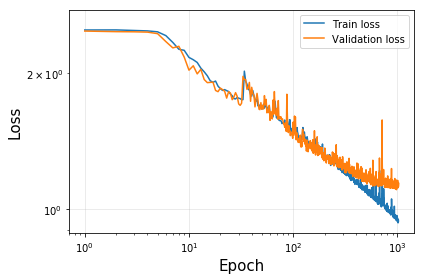

In [60]:
plt.plot(train.epoch, train.loss, label='Train loss')
plt.plot(train.epoch, train.val_loss, label='Validation loss')
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Epoch', fontsize=15); plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best')
plt.grid(lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

Loading trained weight and compiling the model

In [39]:
model.load_weights(weights_path)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

Getting the encoded features and the decoded light curves

In [40]:
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
decoding = decode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`
  


In [41]:
encoding_train = encoding[0:int(0.8*len(X_list))]
encoding_val = encoding[int(0.8*len(X_list)):len(X_list)]
decoding_train = decoding[0:int(0.8*len(X_list))]
decoding_val = decoding[int(0.8*len(X_list)):len(X_list)]
X_raw_train = X_raw[0:int(0.8*len(X_list))]
X_raw_val = X_raw[int(0.8*len(X_list)):len(X_list)]
X_train = X[0:int(0.8*len(X_list))]
X_val = X[int(0.8*len(X_list)):len(X_list)]
scales_train = scales[0:int(0.8*len(X_list))]
scales_val = scales[int(0.8*len(X_list)):len(X_list)]
means_train = means[0:int(0.8*len(X_list))]
means_val = means[int(0.8*len(X_list)):len(X_list)]

### Examples of modeled light curves and encoded features of the training set

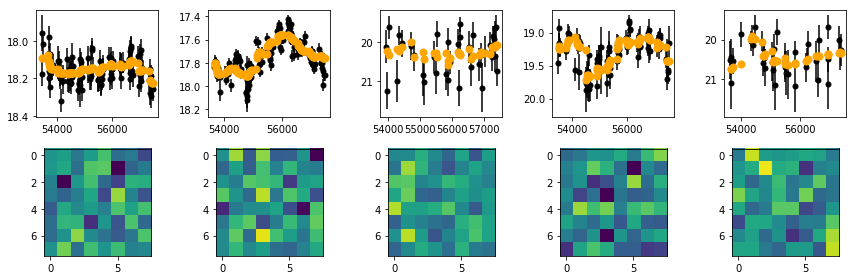

Upper panels: Input light curves (black points) and decoded light curves (orange points) 

Lower panels: Encoded 16 features


In [45]:
i = 0 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_raw_train[num][:,0], X_raw_train[num][:,1], yerr=X_raw_train[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[num][:, 0][X_train[num][:, 0]>0])+X_raw_train[num][0,0], 
             decoding_train[num][X_train[num][:, 0]>0]*scales_train[num]+means_train[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding_train[num].reshape(8,8), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('Catalina_modeled_lc_encoded_features_train.pdf', pad_inches=0.5)
plt.show()

print("""Upper panels: Input light curves (black points) and decoded light curves (orange points) \n
Lower panels: Encoded 16 features""")

### Examples of modeled light curves and encoded features of the validation set

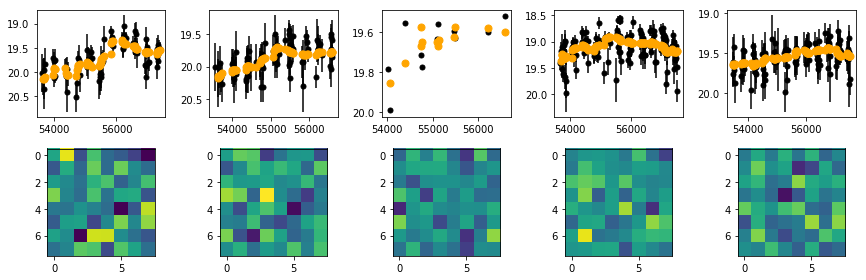

In [48]:
i = 0 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding_val[num].reshape(8,8), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('Catalina_modeled_lc_encoded_features_val.pdf', pad_inches=0.5)
plt.show()


### Distribution of the reduced chi-square

In [49]:
def calc_redchisq(x, x_pred, weight):
    mask =  (~np.isnan(weight))
    out = np.sum(((x[mask]-x_pred[mask])*weight[mask])**2)/len(weight[mask])
    return out

RedChiSq = []
print('Caluculating reduced chi-square for each source')
for m in range(0, len(X_raw)):
    if m%100 == 0:
        print('.', end='')
    RedChiSq.append(calc_redchisq(X[m][:,1]*scales[m]+means[m], np.squeeze(decoding[m]*scales[m]+means[m]), 1/X_raw[m][:,2]))

Caluculating reduced chi-square for each source
...........................................

In [50]:
RedChiSq_train = RedChiSq[0:int(0.8*len(X_list))]
RedChiSq_val = RedChiSq[int(0.8*len(X_list)):len(X_list)]

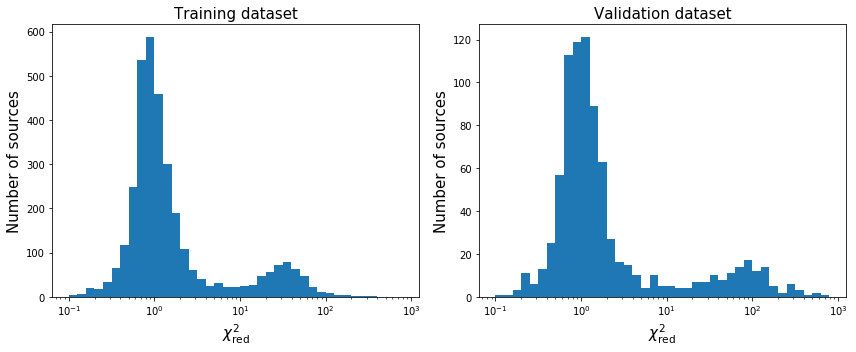

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.array(RedChiSq_train)[~np.isnan(RedChiSq_train)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Training dataset', fontsize=15)
plt.tight_layout()
plt.savefig('Catalina_chi_hist.pdf', pad_inches=0.5)

plt.subplot(1,2,2)
plt.hist(np.array(RedChiSq_val)[~np.isnan(RedChiSq_val)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Validation dataset', fontsize=15)
plt.tight_layout()
plt.savefig('Catalina_chi_hist.pdf', pad_inches=0.5)

plt.tight_layout()
plt.show()

The distribution of the validation dataset shows two peaks. What does this mean??

### Visualizing the distribution of the encoded features by t-SNE

In [52]:
from sklearn.manifold import TSNE

In [53]:
X_reduced_train =TSNE(n_components=2, perplexity=100, random_state=32, n_iter=1000).fit_transform(encoding_train)

In [55]:
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns
from matplotlib import gridspec as grs
from scipy import stats

def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 200, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [56]:
rx, ry, rz = kde_contour_dat(X_reduced_train[:, 0], X_reduced_train[:, 1], grid_bins=100, BW=[2,2], extent=[-50, 50, -50, 50])

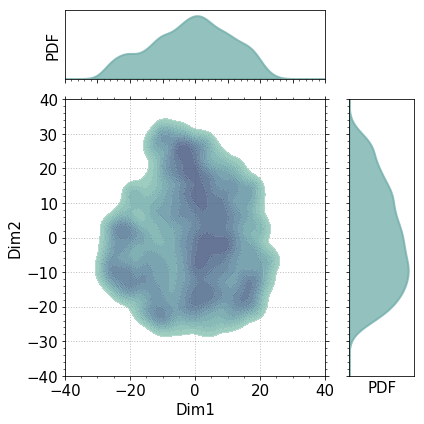

In [332]:
X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]

xlims = [-40, 40]
ylims = [-40, 40]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Catalina_train_tSNE.pdf', pad_inches=0.5)
plt.show()

In [58]:
mask = 10**((np.nanmean(X_raw_train[:, :, 1], axis=1)/-2.5))*1e8 < 4000
f = 10**((np.nanmean(X_raw_train[:, :, 1], axis=1)[mask]/-2.5))*10**8.5
c_scale = (f-np.min(f))/np.std(f)*3

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


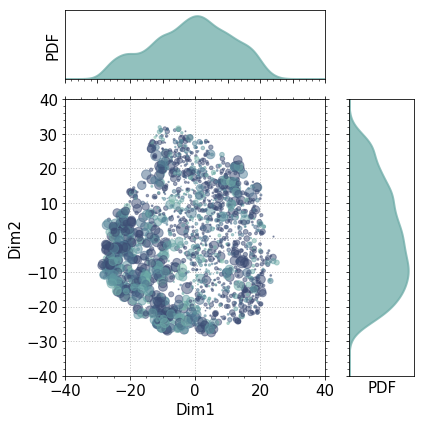

Larger data point indicates larger chi-square 
 
Color indicates the brightness of each source (blue: bright, green: faint)


In [333]:
LogRedChiSq_train = np.log10(RedChiSq_train)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].scatter(X_reduced_train[:, 0], X_reduced_train[:, 1], alpha=0.5, 
              s=LogRedChiSq_train*50, 
              color=cmap(c_scale))
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Catalina_train_tSNE_chi_mag.pdf', pad_inches=0.5)
plt.show()

print("""Larger data point indicates larger chi-square \n 
Color indicates the brightness of each source (blue: bright, green: faint)""")

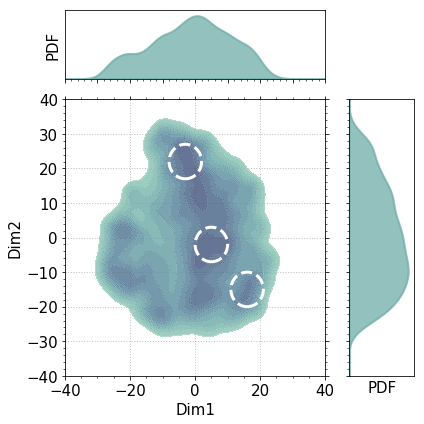

Defining; 

the left circle: region 1 
 
The right circle: region 2


In [67]:
import matplotlib.patches as patches

X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]

xlims = [-40, 40]
ylims = [-40, 40]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
c1 = patches.Circle(xy=(5, -2), radius=5, ec='white', linewidth=3, ls='dashed', fill=False)
c2 = patches.Circle(xy=(-3, 22), radius=5, ec='white', linewidth=3, ls='dashed', fill=False)
c3 = patches.Circle(xy=(16, -15), radius=5, ec='white', linewidth=3, ls='dashed', fill=False)
ax[0].add_patch(c1); ax[0].add_patch(c2); ax[0].add_patch(c3)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Catalina_train_tSNE.pdf', pad_inches=0.5)
plt.show()

print("""Defining; \n
the left circle: region 1 \n 
The right circle: region 2""")

In [72]:
o1 = (5, -2)
o2 = (-3, 22)
o3 = (-16, -15)
rad1 = 2
rad2 = 2
rad3 = 2
reg1_mask = np.sqrt((X_reduced_train[:,0] - o1[0])**2 + (X_reduced_train[:,1] - o1[1])**2) < rad1
reg2_mask = np.sqrt((X_reduced_train[:,0] - o2[0])**2 + (X_reduced_train[:,1] - o2[1])**2) < rad2
reg3_mask = np.sqrt((X_reduced_train[:,0] - o3[0])**2 + (X_reduced_train[:,1] - o3[1])**2) < rad3
np.sum(reg1_mask), np.sum(reg2_mask), np.sum(reg3_mask)

(27, 25, 20)

### Examples of the light curve and features in the region 1

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


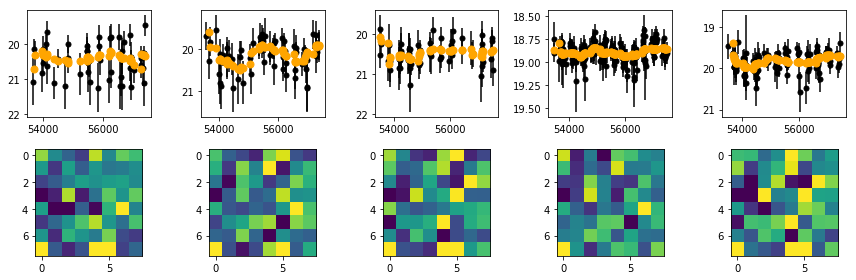

In [76]:
X, means, scales, errors, wrong_units = preprocess(X_raw)
i = 0
k=0
reg_mask = reg1_mask
plt.figure(figsize=(12, 4))
for num in range(i,i+5):
    plt.subplot(2, 5, k+1)
    plt.errorbar(X_raw_train[reg_mask][num][:,0], X_raw_train[reg_mask][num][:,1], 
                 yerr=X_raw_train[reg_mask][num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[reg_mask][num][:, 0][X_train[reg_mask][num][:, 0]>0])+X_raw_train[reg_mask][num][0,0], 
             decoding_train[reg_mask][num][X_train[reg_mask][num][:, 0]>0]*scales_train[reg_mask][num]+means_train[reg_mask][num], 
                 fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    #print(np.array(RedChiSq_train)[reg_mask][num])
    k += 1
plt.tight_layout()
k=0
for num in range(i,i+5):
    plt.subplot(2, 5, k+1+5)
    plt.imshow(encoding_train[reg_mask][num].reshape(8,8), vmin=-1, vmax=1)
    k += 1
#plt.colorbar()
plt.tight_layout()
plt.savefig('Catalina_LC_region1_example.pdf', pad_inches=0.5)

### Examples of the light curve and features in the region 2

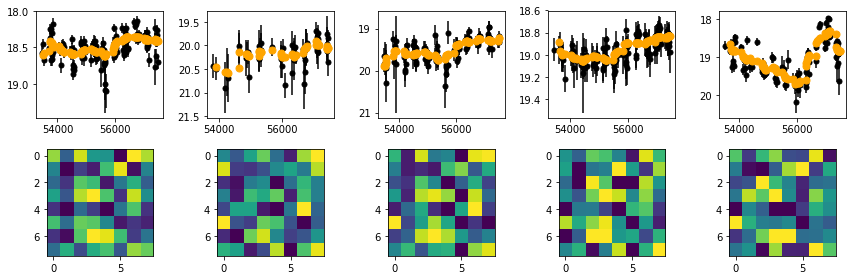

In [77]:
i = 0
k=0
reg_mask = reg2_mask
plt.figure(figsize=(12, 4))
for num in range(i,i+5):
    plt.subplot(2, 5, k+1)
    plt.errorbar(X_raw_train[reg_mask][num][:,0], X_raw_train[reg_mask][num][:,1], 
                 yerr=X_raw_train[reg_mask][num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[reg_mask][num][:, 0][X_train[reg_mask][num][:, 0]>0])+X_raw_train[reg_mask][num][0,0], 
             decoding_train[reg_mask][num][X_train[reg_mask][num][:, 0]>0]*scales_train[reg_mask][num]+means_train[reg_mask][num], 
                 fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    #print(np.array(RedChiSq_train)[reg_mask][num])
    k += 1
plt.tight_layout()
k=0
for num in range(i,i+5):
    plt.subplot(2, 5, k+1+5)
    plt.imshow(encoding_train[reg_mask][num].reshape(8,8), vmin=-1, vmax=1)
    k += 1
#plt.colorbar()
plt.tight_layout()
plt.savefig('Catalina_LC_region2_example.pdf', pad_inches=0.5)

The difference between the region 1 and the region 2 mainly comes from $\Delta t$??

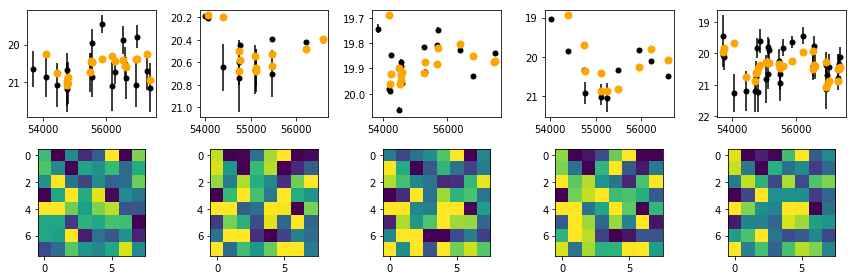

In [78]:
i = 0
k=0
reg_mask = reg3_mask
plt.figure(figsize=(12, 4))
for num in range(i,i+5):
    plt.subplot(2, 5, k+1)
    plt.errorbar(X_raw_train[reg_mask][num][:,0], X_raw_train[reg_mask][num][:,1], 
                 yerr=X_raw_train[reg_mask][num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[reg_mask][num][:, 0][X_train[reg_mask][num][:, 0]>0])+X_raw_train[reg_mask][num][0,0], 
             decoding_train[reg_mask][num][X_train[reg_mask][num][:, 0]>0]*scales_train[reg_mask][num]+means_train[reg_mask][num], 
                 fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    #print(np.array(RedChiSq_train)[reg_mask][num])
    k += 1
plt.tight_layout()
k=0
for num in range(i,i+5):
    plt.subplot(2, 5, k+1+5)
    plt.imshow(encoding_train[reg_mask][num].reshape(8,8), vmin=-1, vmax=1)
    k += 1
#plt.colorbar()
plt.tight_layout()
plt.savefig('Catalina_LC_region3_example.pdf', pad_inches=0.5)

## Example of sources showing a large $\chi_{\rm red}^2$

In [81]:
len_list = []
for i in range(0,len(X_list)):
    len_list.append(len(X_list[i]))

In [89]:
chi_mask = np.array(RedChiSq) > 10

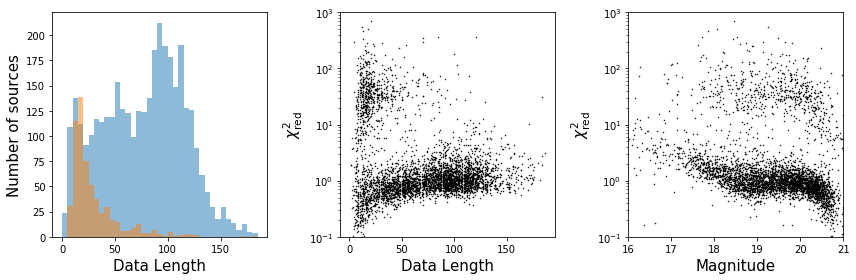

In [225]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.hist(np.array(len_list)[~chi_mask], bins=np.arange(0, 190, 5), alpha=0.5)
plt.hist(np.array(len_list)[chi_mask], bins=np.arange(0, 190, 5), alpha=0.5)
plt.xlabel('Data Length', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.subplot(1,3,2)
plt.scatter(len_list, RedChiSq, alpha=1, s=0.25, color='black')
plt.xlabel('Data Length', fontsize=15)
plt.ylabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylim(1e-1, 1e3)
plt.yscale('log')
plt.subplot(1,3,3)
plt.scatter(np.nanmean(X_raw[:, :, 1], axis=1), RedChiSq, alpha=1, s=0.25, color='black')
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylim(1e-1, 1e3);plt.xlim(16, 21)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [139]:
len_mask = np.array(len_list)>68

In [214]:
X_list_org = load_lcs('./lcs/')
command = 'ls ' + str('./lcs/')
lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')

Loading 4227 data:
Finish.


In [215]:
bad_fitting_mask = len_mask&chi_mask

In [216]:
bad_fitting_lc_id = []
for i in range(0,np.sum(bad_fitting_mask)):
    val_top = X_raw[bad_fitting_mask][i][0]
    for j in range(0,len(X_list)):
        if np.sum(val_top == X_list_org[j][0])==3:
            bad_fitting_lc_id.append(lc_files[j])

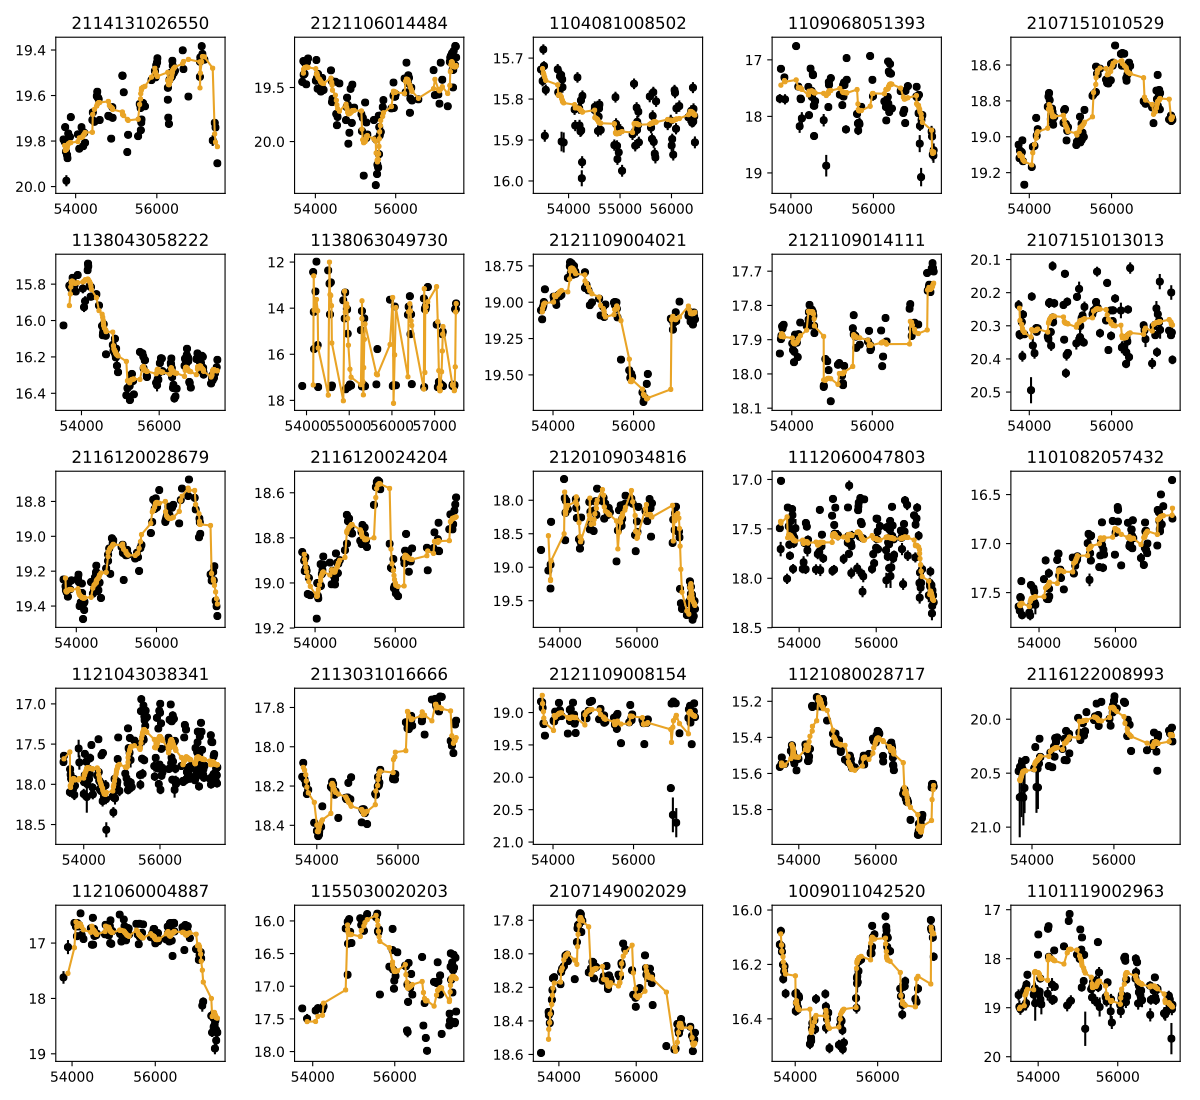

In [240]:
display_png(Image('./Catalina_LC_bad_fitting_example1.png'))

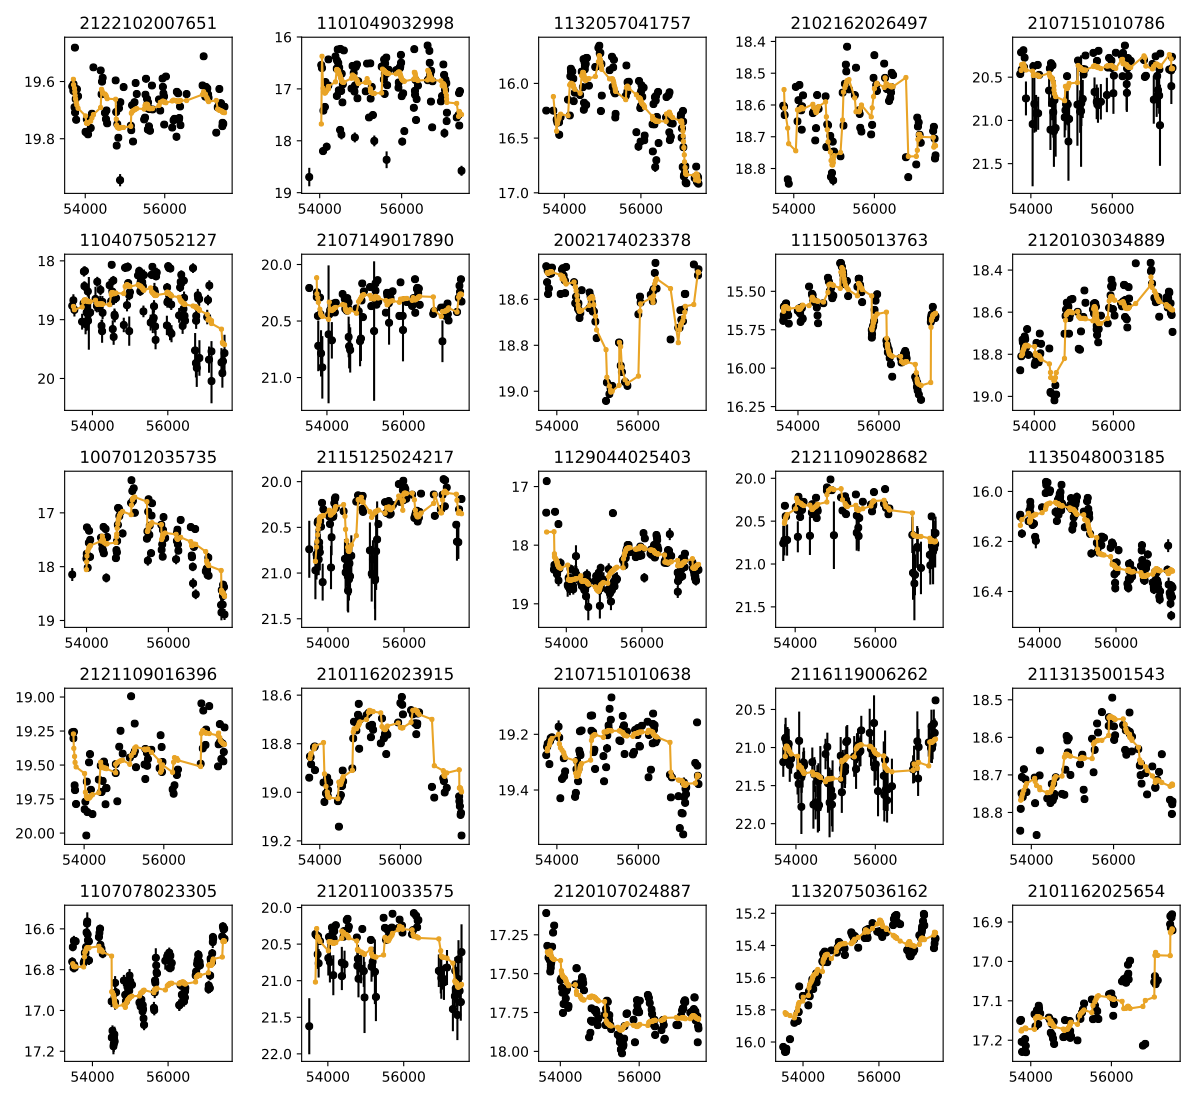

In [241]:
display_png(Image('./Catalina_LC_bad_fitting_example2.png'))

## Example of sources showing a small $\chi_{\rm red}^2$

In [244]:
chi_good_mask = np.array(RedChiSq) < 1.2

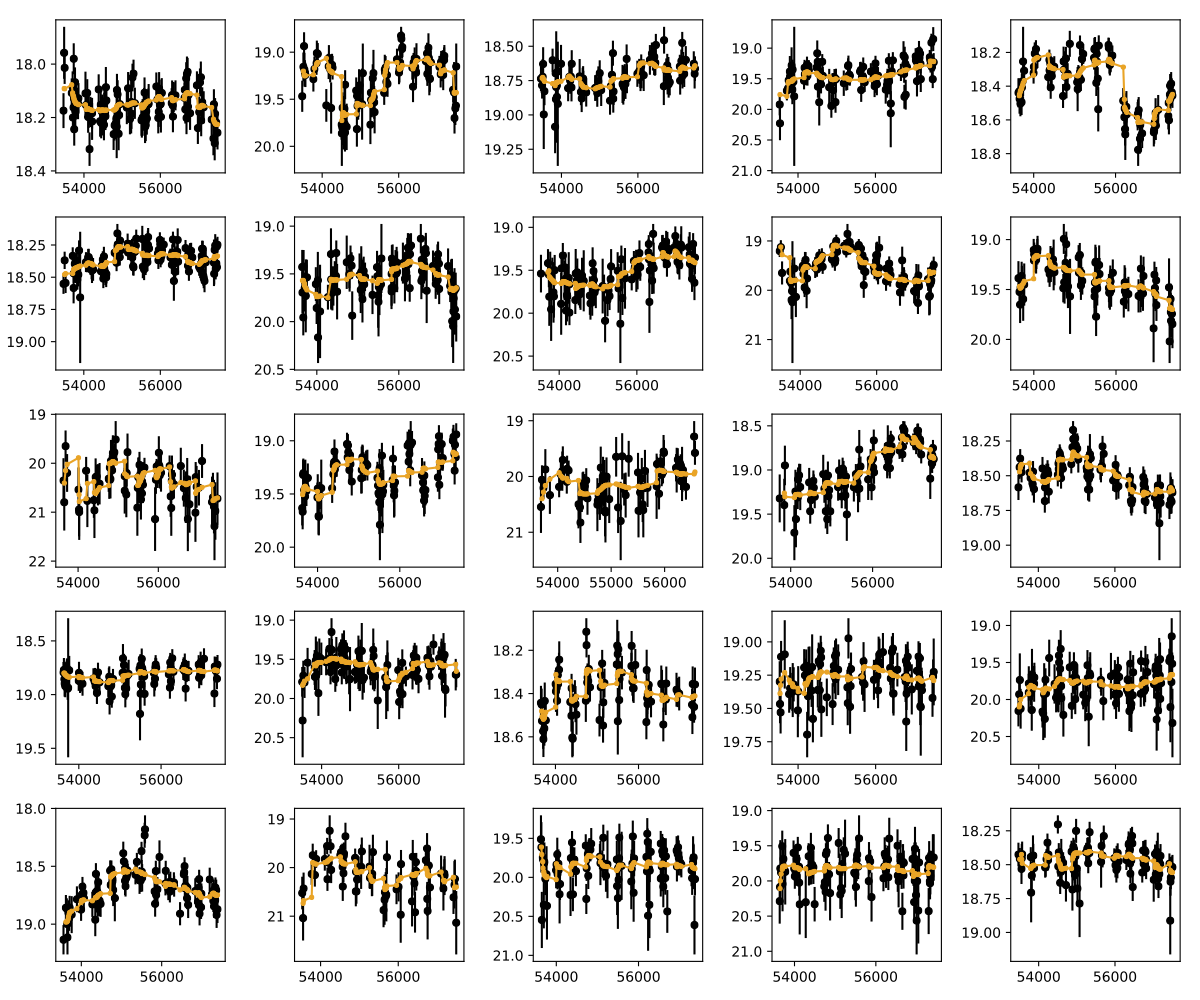

In [242]:
display_png(Image('./Catalina_LC_good_fitting_example1.png'))

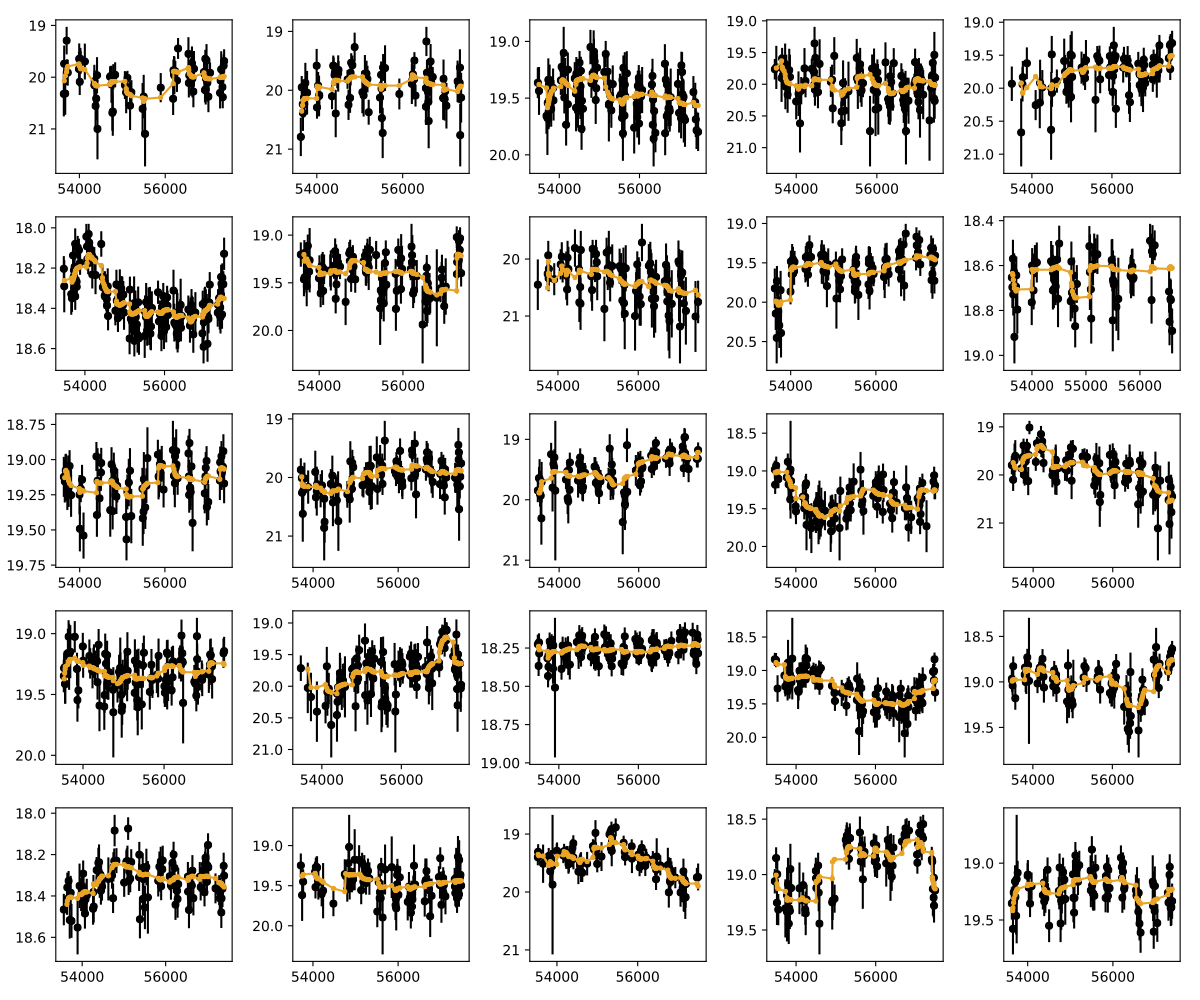

In [243]:
display_png(Image('./Catalina_LC_good_fitting_example2.png'))

In [249]:
df = pd.DataFrame(encoding)

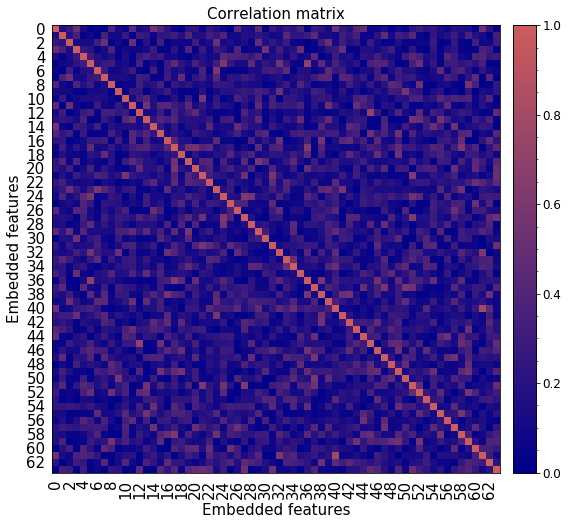

In [276]:
import mpl_toolkits.axes_grid1
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['darkblue', 'indianred'])


def correlation_matrix(df):

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    ax1.tick_params(bottom="off", left='off')
    cmap = cm
    cax = ax1.imshow(np.abs(df.corr()), interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    #ax1.grid(True)
    plt.title('Correlation matrix', fontsize=15)
    plt.xlabel('Embedded features', fontsize=15)
    plt.ylabel('Embedded features', fontsize=15)
    labels=np.arange(0, len(df.T[0]), 2)
    ax1.set_xticks(np.arange(0, len(df.T[0]), 2))
    ax1.set_yticks(np.arange(0, len(df.T[0]), 2))
    ax1.set_xticklabels(labels,fontsize=15, rotation =90)
    ax1.set_yticklabels(labels,fontsize=15)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
    cax_ = divider.append_axes('right', '5%', pad='3%')
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.2), cax=cax_).ax.tick_params(labelsize=12)
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.2), cax=cax_).ax.minorticks_on()
    plt.tight_layout()

correlation_matrix(df)
plt.savefig('CorrelationMatrix_64features.pdf', pad_inches=0.5)

In [284]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [409]:
Catalina_linkage_result = linkage(df, method='ward', metric='euclidean')

In [438]:
threshold = 0.75 * np.max(Catalina_linkage_result[:, 2])

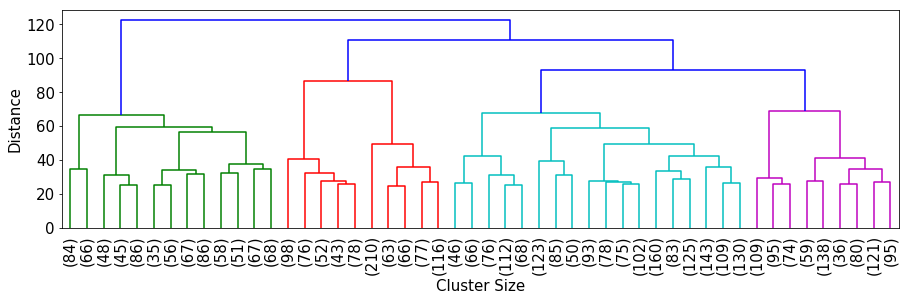

In [457]:
plt.figure(num=None, figsize=(15, 4), facecolor='w', edgecolor='k')
dendrogram(Catalina_linkage_result, color_threshold=threshold, truncate_mode='lastp', p=50)
plt.tick_params(labelsize = 15)
plt.xlabel('Cluster Size', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.show()

In [440]:
Catalina_clustered = fcluster(Catalina_linkage_result, threshold, criterion='distance')

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


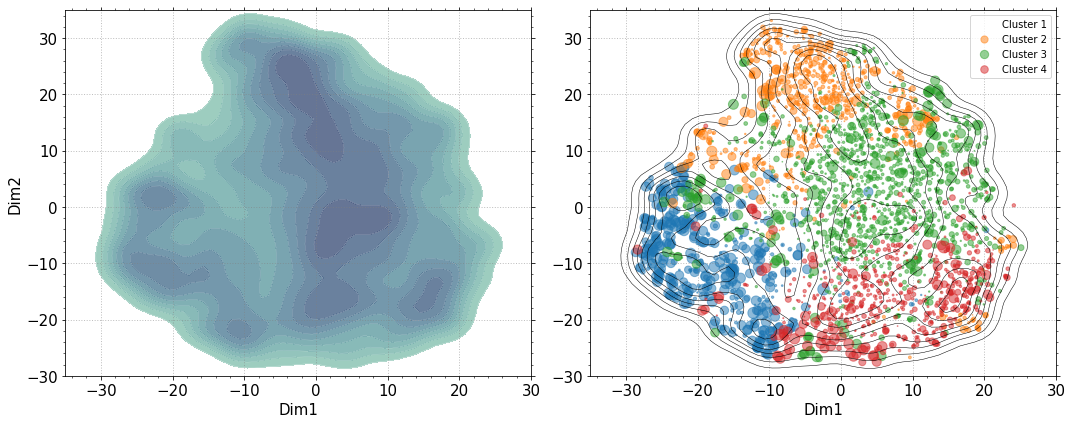

In [455]:
xlims = [-35, 30]
ylims = [-30, 35]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
plt.ylabel('Dim2', fontsize=15)

plt.subplot(1,2,2)
plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("black",), alpha = 1, zorder = 11)
for cl in range(1, np.max(Catalina_clustered)+1):
    label = 'Cluster ' + str(cl)
    plt.scatter(X_reduced_train[:, 0][Catalina_clustered[0:int(0.8*len(X_list))]==cl], 
                X_reduced_train[:, 1][Catalina_clustered[0:int(0.8*len(X_list))]==cl], alpha=0.5, 
                  s=LogRedChiSq_train[Catalina_clustered[0:int(0.8*len(X_list))]==cl]*50+10, label = label)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
#plt.ylabel('Dim2', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('Catalina_Clustered.pdf', pad_inches=0.5)